In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega
import seaborn as sns
# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

In [4]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = '192.168.60.144'
    conn_info["sqlport"] = 6432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == '192.168.60.144') & (conn_info["sqlport"]=='6432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [5]:
from sqlalchemy import create_engine,text
con= create_engine('postgresql://eicu@192.168.60.144:6432/eicu')

In [6]:
datadir = '/home/mei/nas/docker/dataset/EICU/eicu-collaborative-research-database-2.0/'
porcesseddir2 = '/home/mei/nas/docker/processedData_2/'

## 筛选出病人来自 direct 和 emergency 并且 住icu时长为 1到14天的病人

In [5]:
create_table_patient = query_schema + """

DROP TABLE IF EXISTS patient_2 CASCADE;
CREATE TABLE patient_2 as
SELECT DISTINCT patientunitstayid, hospitaladmitOffset, gender, age, apacheadmissiondx, unitadmitsource, admissionweight,	dischargeweight, unitdischargeoffset, unitdischargelocation,	unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Direct Admit') 
    AND unitdischargeoffset >=1440 
    AND unitdischargeoffset <=20160
group by patientunitstayid, hospitaladmitOffset
order by patientunitstayid, hospitaladmitOffset
      
"""
# df_p = pd.read_sql_query(query, con)

In [15]:
# with con.begin() as connection:
#     connection.execute(text(create_table_patient))  # Use text() to wrap the raw SQL

patient_2 = "SELECT * FROM patient_2;"
df_patient = pd.read_sql_query(text(patient_2),con)

In [16]:
df_patient.head(n=20)

,patientunitstayid,hospitaladmitoffset,gender,age,apacheadmissiondx,unitadmitsource,admissionweight,dischargeweight,unitdischargeoffset,unitdischargelocation,unitdischargestatus
0,141168,0,Female,70,"Rhythm disturbance (atrial, supraventricular)",Direct Admit,84.3,85.8,3596,Death,Expired
1,141265,-1,Male,67,"CVA, cerebrovascular accident/stroke",Direct Admit,100.0,91.8,6068,Floor,Alive
2,141266,-18,Male,73,"Sepsis, renal/UTI (including bladder)",Emergency Department,120.4,112.9,1501,Floor,Alive
3,141276,-1,Female,59,"Arrest, respiratory (without cardiac arrest)",Direct Admit,156.6,156.6,1684,Home,Alive
4,141284,-15,Male,63,Anemia,Direct Admit,NaN,88.5,2076,Floor,Alive
5,141288,-171,Female,61,"Sepsis, pulmonary",Emergency Department,NaN,92.2,1631,Floor,Alive
6,141304,-3,Male,70,"Sepsis, pulmonary",Emergency Department,NaN,68.0,6639,Floor,Alive
7,141329,-87,Male,50,"Infarction, acute myocardial (MI)",Direct Admit,79.0,79.3,2572,Floor,Alive
8,141360,-30,Male,48,"CVA, cerebrovascular accident/stroke",Emergency Department,NaN,92.3,3109,Floor,Alive
9,141415,-347,Male,30,"Thrombosis, vascular (deep vein)",Direct Admit,87.1,86.7,4430,Floor,Alive


In [18]:
# df_patient.to_csv(porcesseddir2 + 'selected_patient.csv',  index=False)

In [19]:
n =df_patient['patientunitstayid'].nunique()
print("There are {} unique patientunitstayid patients from the unitadmitsource: emergency and direct with a stay length between 1 and 14 days.".format(n))

There are 68446 unique patientunitstayid patients from the unitadmitsource: emergency and direct with a stay length between 1 and 14 days.


In [20]:
df_p=df_patient.copy()


In [21]:

frequency_table =df_p.groupby(['unitdischargelocation', 'unitdischargestatus']).size().reset_index(name='count')
print(frequency_table)


       unitdischargelocation unitdischargestatus  count
0                                                     4
1                                          Alive     66
2           Acute Care/Floor               Alive   6725
3                      Death             Expired   3452
4                      Floor               Alive  33902
5                       Home               Alive   6909
6                        ICU               Alive    216
7               Nursing Home               Alive    135
8             Operating Room               Alive      4
9                      Other               Alive    530
10            Other External               Alive   1122
11            Other Hospital               Alive   1250
12                 Other ICU               Alive   1045
13          Other ICU (CABG)               Alive      3
14            Other Internal               Alive     98
15            Rehabilitation               Alive    219
16  Skilled Nursing Facility               Alive

- Home：恢复最好
- Floor、Rehabilitation、Acute Care/Floor：表示病情有所好转。
- Step-Down Unit (SDU)、Skilled Nursing Facility、Other：患者需要监护，情况相对中等。
- ICU、Operating Room、Other ICU，Other ICU (CABG)：病情较为严重。
- Death 最严重的情况。

## 统计 nan 值

In [22]:
missing_ratio = pd.DataFrame(df_p.isna().sum() / len(df_p.index), columns = ['missing ratio %']) * 100
missing_ratio.sort_values('missing ratio %', inplace = True, ascending = False) 
missing_ratio

,missing ratio %
dischargeweight,38.985478
admissionweight,2.023493
patientunitstayid,0.000000
hospitaladmitoffset,0.000000
gender,0.000000
age,0.000000
apacheadmissiondx,0.000000
unitadmitsource,0.000000
unitdischargeoffset,0.000000
unitdischargelocation,0.000000


In [18]:
freq_l = pd.DataFrame()
freq_l['noAnnotations'] = df_p['unitdischargelocation'].value_counts() 
freq_l['%'] = df_p['unitdischargelocation'].value_counts() / len(df_p.index) * 100
freq_l

,noAnnotations,%
unitdischargelocation,,
Floor,33902,49.531017
Step-Down Unit (SDU),7617,11.128481
Home,6909,10.094089
Acute Care/Floor,6725,9.825264
Telemetry,4325,6.318850
Death,3452,5.043392
Other Hospital,1250,1.826257
Other External,1122,1.639248
Other ICU,1045,1.526751


In [23]:
freq_s = pd.DataFrame()
freq_s['noAnnotations'] = df_p['unitdischargestatus'].value_counts() 
freq_s['%'] = df_p['unitdischargestatus'].value_counts() / len(df_p.index) * 100
freq_s

,noAnnotations,%
unitdischargestatus,,
Alive,64990,94.950764
Expired,3452,5.043392
,4,0.005844


## analysis the relation between unitdischargelocation', 'unitdischargeoffset' and risk sore

In [24]:
cols=[ 'patientunitstayid', 'unitdischargeoffset','unitdischargelocation']
df_p1=df_p[cols]

In [7]:
# df_p1.to_csv(porcesseddir2 + 'selected_patient_relation_function.csv',index=False)

df_p1=pd.read_csv(porcesseddir2 + 'selected_patient_relation_function.csv',index_col=False)


In [8]:
df_p1.head()

,patientunitstayid,unitdischargeoffset,unitdischargelocation
0,141168,3596,Death
1,141265,6068,Floor
2,141266,1501,Floor
3,141276,1684,Home
4,141284,2076,Floor


In [9]:
def classify_discharge_location(location):
    high_risk = ['ICU', 'Other ICU', 'Other ICU (CABG)', 'Operating Room']
    medium_risk = ['Telemetry', 'Other Hospital', 'Other External',  'Other Internal','Step-Down Unit (SDU)']
    low_risk = ['Nursing Home', 'Skilled Nursing Facility', 'Floor', 'Acute Care/Floor','Rehabilitation']
    home= ['Home']
    death = ['Death']
    
    if location in high_risk:
        return 'High Risk'
    elif location in medium_risk:
        return 'Medium Risk'
    elif location in low_risk:
        return 'Low Risk'
    elif location in death:
        return 'Death'
    elif location in home:
        return 'Home'
    else:
        return 'Unknown'

# 应用分类
df_p1['discharge_risk_category'] = df_p1['unitdischargelocation'].apply(classify_discharge_location)

# 检查分类结果
print(df_p1[['unitdischargelocation', 'discharge_risk_category']].head())

  unitdischargelocation discharge_risk_category
0                 Death                   Death
1                 Floor                Low Risk
2                 Floor                Low Risk
3                  Home                    Home
4                 Floor                Low Risk


In [10]:

# 定义 risk score 函数
def calculate_risk_score(discharge_risk_category, offset):
    # 高风险的出院地点
    if discharge_risk_category == 'Death':
        return 0.6 + (1.0 - 0.6) * np.exp(-0.0006 * offset)  # 越接近出院，风险越高
    # 中高风险的出院地点
    elif discharge_risk_category == 'High Risk':
        return 0.55 + (0.4 - 0.55) * np.exp(-0.00055 * offset)
     # 中风险的出院地点
    elif discharge_risk_category =='Medium Risk':
        return 0.5 + (0.3 - 0.5) * np.exp(-0.0005 * offset)
    # 低风险的出院地点
    elif discharge_risk_category=='Low Risk':
        return 0.45 + (0.2-0.45) * np.exp(-0.00045 * offset)
    # 其他地点
    elif discharge_risk_category=='Home':
        return 0.40 *( 1-np.exp(-0.0003 * offset))

# 应用到数据
df_p1['risk_score'] = df_p1.apply(lambda row: calculate_risk_score(row['discharge_risk_category'], row['unitdischargeoffset']), axis=1)

# 查看结果
df_p1[['unitdischargelocation', 'unitdischargeoffset','discharge_risk_category','risk_score']].head()


,unitdischargelocation,unitdischargeoffset,discharge_risk_category,risk_score
0,Death,3596,Death,0.646241
1,Floor,6068,Low Risk,0.433705
2,Floor,1501,Low Risk,0.322768
3,Home,1684,Home,0.158646
4,Floor,2076,Low Risk,0.351775


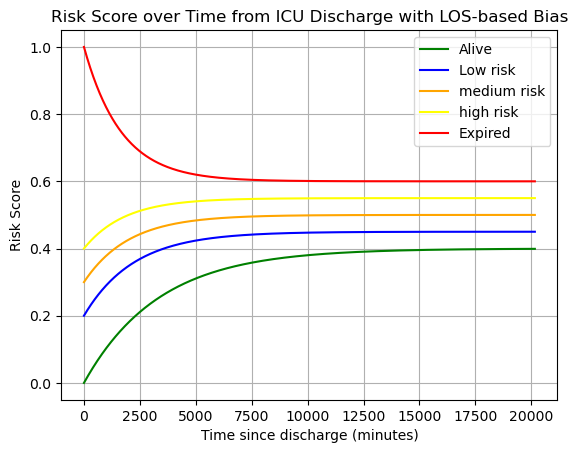

In [11]:
import numpy as np
import matplotlib.pyplot as plt



# 动态增长函数
def risk_alive(t, R0,alpha, bias):
    return R0 * (1 - np.exp(-alpha * t)) + bias

# low risk 模型
def risk_low(t, R1, beta, bias):
    return R1 * (np.exp(-beta * t)) + bias

# medium  risk 模型
def risk_medium(t, R2, gamma, bias):
    return R2 * ( np.exp(-gamma * t)) + bias

# high risk 模型
def risk_high(t, R3, delta, bias):
    return R3 * (np.exp(-delta * t)) + bias

# 动态衰减函数
def risk_expired(t, R4, omega, bias):
    return (R4 * np.exp(-omega * t)) + bias


# 定义时间轴（以分钟为单位，0到14天）
t = np.linspace(0, 14 * 24 * 60, 1000)  # 14天的时间，单位是分钟

# # 定义病人的住院时长（例如住院10天，单位为分钟）
# LOS = 10 * 24 * 60  # 10天住院时长

# # 定义偏置项，假设 bias 是住院时长的某个比例
# bias_expired = 1 * (10 / (14 ))  # 比如对 expired 偏置更大
# bias_alive = 0.1* (1/ (14 ))  # 对 alive 的影响较小
# bias_step_down = 0.3 * (5 / (14))

# 计算每个时间点的风险值
risk_alive_values = risk_alive(t, R0=0.4,alpha=0.0003, bias=0)
risk_low_values = risk_low(t, R1=(0.2-0.45), beta=0.00045, bias=0.45)
risk_medium_values = risk_medium(t, R2=(0.3-0.5), gamma=0.0005, bias=0.5)
risk_high_values = risk_high(t, R3=(0.4-0.55), delta=0.00055, bias=0.55)
risk_expired_values = risk_expired(t, R4=(1.0-0.6), omega=0.0006, bias=0.6)

# 绘制图形


plt.plot(t, risk_alive_values, label="Alive", color="green")
plt.plot(t, risk_low_values, label="Low risk", color="blue")
plt.plot(t, risk_medium_values , label="medium risk", color="orange")
plt.plot(t, risk_high_values, label="high risk", color="yellow")
plt.plot(t, risk_expired_values, label="Expired", color="red")


plt.xlabel("Time since discharge (minutes)")
plt.ylabel("Risk Score")
plt.title("Risk Score over Time from ICU Discharge with LOS-based Bias")
plt.legend()
plt.grid(True)
plt.show()
